In [110]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from glob import glob

# k将所有数据集合并
csv_files = glob('my_data/*.csv')
print(csv_files)
dataframes = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        dataframes.append(df)
    except Exception as e:
        print(f"读取文件 {file} 时出错: {e}")

if len(dataframes) == 0:
    print("没有数据文件")
    exit(1)
else:
    data = pd.concat(dataframes, ignore_index=True)
    
    # 删除指定列
    columns_to_drop = [
        '房源核验统一编码', '查询房管备案记录', '核心卖点', '适宜人群', '别墅类型', '户型介绍', 
        '小区介绍', '售房详情', '税费解析', '周边配套', '用水类型', '用电类型', '装修描述', 
        '燃气价格', '交通出行', '权属抵押', '抵押信息', '楼户比例', '所在楼层'
    ]
    data.drop(columns=columns_to_drop, inplace=True, errors='ignore')  # 使用 errors='ignore' 以防止列不存在的错误
    
    # 修改第一列，从第二行开始从大到小编号
    data['Unnamed: 0'] = range(1, data.shape[0]+1, 1)
    
    # 修改第一列名称为”序号“
    data.rename(columns={'Unnamed: 0': '序号'}, inplace=True)
    
    print(data.shape)  # 打印删除列后数据框的形状
    print(data.head())  # 打印前几行数据，检查列是否正确删除

['my_data\\binjiang杭州二手房.csv', 'my_data\\fuyang杭州二手房.csv', 'my_data\\gongshu杭州二手房.csv', 'my_data\\linan杭州二手房.csv', 'my_data\\linpingqu杭州二手房.csv', 'my_data\\qiantangqu杭州二手房.csv', 'my_data\\shangcheng杭州二手房.csv', 'my_data\\xiaoshan杭州二手房.csv', 'my_data\\xihu杭州二手房.csv', 'my_data\\yuhang杭州二手房.csv']


(29027, 27)
   序号         小区名称      区域位置          经度         纬度     总价     单价      看房时间  \
0   1  ['欣盛东方郡西区']  滨江-滨江区政府  120.218825  30.203884  930.0  69053  提前预约随时可看   
1   2   ['铂金时代公寓']  滨江-滨江区政府  120.223773  30.201048  765.0  55423     下班后可看   
2   3      ['星耀城']  滨江-滨江区政府  120.221367  30.219193  225.0  34611  提前预约随时可看   
3   4    ['中赢康康谷']  滨江-滨江区政府  120.220640  30.202140  148.0  31835  提前预约随时可看   
4   5      ['玲珑府']     滨江-西兴  120.232076  30.189648  130.0  26461  提前预约随时可看   

           链家编号  关注度  ... 装修情况    梯户比例 配备电梯        挂牌时间 交易权属        上次交易  \
0  103117810968    4  ...   精装    四梯两户    有  2021-10-26  商品房  2011-07-18   
1  103117801479    7  ...   精装    三梯三户    有  2021-10-26  商品房  2012-05-04   
2  103108527621  104  ...   精装  四梯二十四户    有  2020-04-12  商品房  2015-04-02   
3  103117403346   18  ...   精装  两梯三十一户    有  2021-09-28  商品房  2018-12-30   
4  103117598758   11  ...   精装   三梯十九户    有  2021-10-12  商品房  2018-05-16   

   房屋用途 房屋年限 产权所属     房本备件  
0  普通住宅  满五年   共有  已上传房本照片 

In [111]:
# 提取需要的列
data_lite = pd.DataFrame()
data_lite['序号'] = data['序号']
data_lite['链家编号'] = data['链家编号']
data_lite['建筑面积'] = data['建筑面积'].str.replace('㎡', '').astype(float)  # 转换为浮点型
data_lite['区域位置'] = data['区域位置']
data_lite['单价'] = data['单价']

# 提取卧室数量和浴室数量，空值处理为-1
data_lite['卧室数量'] = data['房屋户型'].str.extract(r'(\d+)室').fillna(-1).astype(int)
data_lite['浴室数量'] = data['房屋户型'].str.extract(r'(\d+)卫').fillna(-1).astype(int)

# 计算房屋的年龄
current_year = pd.Timestamp.now().year
data_lite['上次交易'] = pd.to_datetime(data['上次交易'], errors='coerce')
data_lite['房屋年龄'] = current_year - data_lite['上次交易'].dt.year
data_lite['房屋年龄'] = data_lite['房屋年龄'].fillna(-1).astype(int)  # 空值处理为-1

# 删除无用列
data_lite = data_lite.drop(columns=['上次交易'])

# 打印数据框的形状和前几行数据
print(data_lite.shape)
print(data_lite.head())

(29027, 8)
   序号          链家编号    建筑面积      区域位置     单价  卧室数量  浴室数量  房屋年龄
0   1  103117810968  134.68  滨江-滨江区政府  69053     3     2    13
1   2  103117801479  138.03  滨江-滨江区政府  55423     3     2    12
2   3  103108527621   65.01  滨江-滨江区政府  34611     3     2     9
3   4  103117403346   46.49  滨江-滨江区政府  31835     2     2     6
4   5  103117598758   49.13     滨江-西兴  26461     2     2     6


In [112]:
# 保存这个关键数据
data_lite.to_csv('data.csv', index=False)

In [113]:
# 检查其中值为-1的数量
print(data_lite[data_lite == -1].count())

序号        0
链家编号      0
建筑面积      0
区域位置      0
单价        0
卧室数量      6
浴室数量      6
房屋年龄    632
dtype: int64


In [114]:
# 加载数据集
data_lite = pd.read_csv('data.csv')

# 根据区域位置提取市区信息
data_lite['市区'] = data_lite['区域位置'].apply(lambda x: x.split('-')[0])

# 将地理位置（区域位置）转换为数值型特征（独热编码）
encoder = OneHotEncoder(sparse_output=False)
location_encoded = encoder.fit_transform(data_lite[['市区']])
location_df = pd.DataFrame(location_encoded, columns=encoder.get_feature_names_out(['市区']))

data_lite = pd.concat([data_lite, location_df], axis=1).drop(columns=['区域位置', '市区'])

# 打印数据框的形状和前几行数据
print(data_lite.shape)
print(data_lite.head())

(29027, 17)
   序号          链家编号    建筑面积     单价  卧室数量  浴室数量  房屋年龄  市区_上城  市区_临安  市区_临平区  \
0   1  103117810968  134.68  69053     3     2    13    0.0    0.0     0.0   
1   2  103117801479  138.03  55423     3     2    12    0.0    0.0     0.0   
2   3  103108527621   65.01  34611     3     2     9    0.0    0.0     0.0   
3   4  103117403346   46.49  31835     2     2     6    0.0    0.0     0.0   
4   5  103117598758   49.13  26461     2     2     6    0.0    0.0     0.0   

   市区_余杭  市区_富阳  市区_拱墅  市区_滨江  市区_萧山  市区_西湖  市区_钱塘区  
0    0.0    0.0    0.0    1.0    0.0    0.0     0.0  
1    0.0    0.0    0.0    1.0    0.0    0.0     0.0  
2    0.0    0.0    0.0    1.0    0.0    0.0     0.0  
3    0.0    0.0    0.0    1.0    0.0    0.0     0.0  
4    0.0    0.0    0.0    1.0    0.0    0.0     0.0  


In [115]:
# 计算每个区域的平均值
region_columns = [col for col in data_lite.columns if col.startswith('市区_')]
for col in ['卧室数量', '浴室数量', '房屋年龄']:
    for region_col in region_columns:
        mean_value = data_lite.groupby(region_col)[col].mean()
        data_lite[col] = np.where((data_lite[col] == -1) & (data_lite[region_col] == 1), mean_value[data_lite[region_col]], data_lite[col])

# 打印填充后的数据
print(data_lite.head())

# 将其中第四列“总价”以及后面的所有数据都转化为整数
for col in data_lite.columns[3:]:
    data_lite[col] = data_lite[col].astype(int)

# 保存填充后的数据
data_lite.to_csv('data_filled.csv', index=False)

   序号          链家编号    建筑面积     单价  卧室数量  浴室数量  房屋年龄  市区_上城  市区_临安  市区_临平区  \
0   1  103117810968  134.68  69053   3.0   2.0  13.0    0.0    0.0     0.0   
1   2  103117801479  138.03  55423   3.0   2.0  12.0    0.0    0.0     0.0   
2   3  103108527621   65.01  34611   3.0   2.0   9.0    0.0    0.0     0.0   
3   4  103117403346   46.49  31835   2.0   2.0   6.0    0.0    0.0     0.0   
4   5  103117598758   49.13  26461   2.0   2.0   6.0    0.0    0.0     0.0   

   市区_余杭  市区_富阳  市区_拱墅  市区_滨江  市区_萧山  市区_西湖  市区_钱塘区  
0    0.0    0.0    0.0    1.0    0.0    0.0     0.0  
1    0.0    0.0    0.0    1.0    0.0    0.0     0.0  
2    0.0    0.0    0.0    1.0    0.0    0.0     0.0  
3    0.0    0.0    0.0    1.0    0.0    0.0     0.0  
4    0.0    0.0    0.0    1.0    0.0    0.0     0.0  


In [116]:
data = pd.read_csv('data_filled.csv')

# 定义函数处理每列中的异常值
def replace_outliers_with_mean(column):
    # 计算第一四分位数（Q1）和第三四分位数（Q3）
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    # 计算四分位距（IQR）
    IQR = Q3 - Q1
    # 定义异常值的上下界
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # 替换异常值为该列的均值
    column.loc[(column < lower_bound) | (column > upper_bound)] = column.mean()
    return column


# 遍历除了序号和链家编号之外的所有列，处理异常值
for col in data.columns[2:6]:  # 从第三列开始，因为前两列是序号和链家编号
    data[col] = replace_outliers_with_mean(data[col])

C:\Users\Liu_Q\AppData\Local\Temp\ipykernel_29024\3365022166.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[(column < lower_bound) | (column > upper_bound)] = column.mean()
C:\Users\Liu_Q\AppData\Local\Temp\ipykernel_29024\3365022166.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column.loc[(column < lower_bound) | (column > upper_bound)] = column.mean()
C:\Users\Liu_Q\AppData\Local\Temp\ipykernel_29024\3365022166.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '36431.17907465463' has dtype incompatible with int64, please

In [117]:
# 特征工程，添加面积卧室数量比和年龄的平方
data = pd.read_csv('data_filled.csv')

# 添加面积/卧室数量的比例列
data['area'] = data['建筑面积'] / data['卧室数量'].astype(float)

# 添加年龄的平方列
data['age_squared'] = data['房屋年龄'] ** 2

print(data.head())

   序号          链家编号    建筑面积     单价  卧室数量  浴室数量  房屋年龄  市区_上城  市区_临安  市区_临平区  \
0   1  103117810968  134.68  69053     3     2    13      0      0       0   
1   2  103117801479  138.03  55423     3     2    12      0      0       0   
2   3  103108527621   65.01  34611     3     2     9      0      0       0   
3   4  103117403346   46.49  31835     2     2     6      0      0       0   
4   5  103117598758   49.13  26461     2     2     6      0      0       0   

   市区_余杭  市区_富阳  市区_拱墅  市区_滨江  市区_萧山  市区_西湖  市区_钱塘区       area  age_squared  
0      0      0      0      1      0      0       0  44.893333          169  
1      0      0      0      1      0      0       0  46.010000          144  
2      0      0      0      1      0      0       0  21.670000           81  
3      0      0      0      1      0      0       0  23.245000           36  
4      0      0      0      1      0      0       0  24.565000           36  


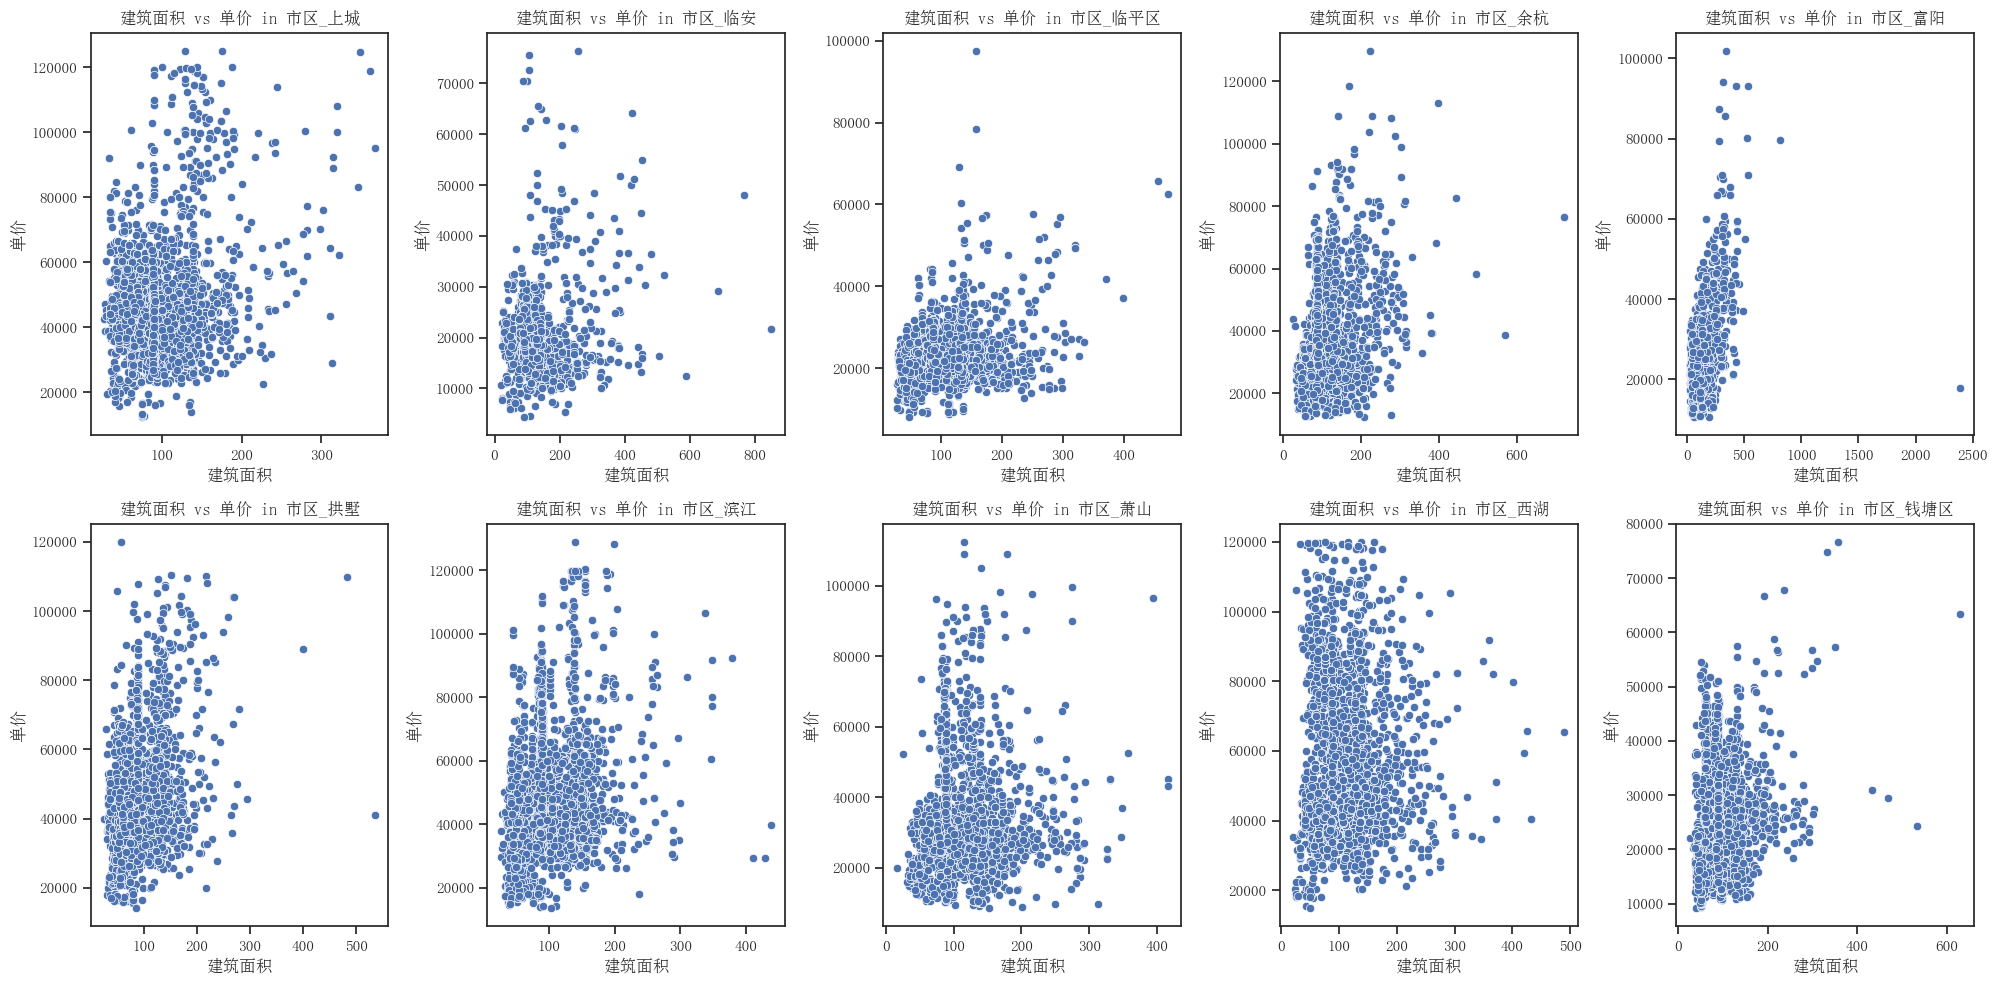

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 设置字体和负号处理
from matplotlib import rcParams
config = {
        "font.family": 'serif',
        "mathtext.fontset": 'stix',  # matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
        "font.serif": ['SimSun'],  # 宋体
        'axes.unicode_minus': False  # 处理负号，即-号
    }
rcParams.update(config)

# 获取市区列表
districts = ['市区_上城', '市区_临安', '市区_临平区', '市区_余杭', '市区_富阳',
            '市区_拱墅', '市区_滨江', '市区_萧山', '市区_西湖', '市区_钱塘区']


# 定义函数绘制关系图
def plot_relationships(data, x_col, y_col, district, ax):
    sns.scatterplot(x=x_col, y=y_col, data=data[data[district] == 1], ax=ax)
    ax.set_title(f'{x_col} vs {y_col} in {district}')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    
# 创建子图布局
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# 遍历每个市区进行可视化
for i, district in enumerate(districts):
    row = i // 5
    col = i % 5
    plot_relationships(data, '建筑面积', '单价', district, axes[row, col])


# 调整布局
plt.tight_layout()
plt.show()

In [119]:
# 保存添加了两列的数据
data.to_csv('data_featured.csv', index=False)

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 加载数据
data = pd.read_csv('data_featured.csv')
data = data.astype(float)

# 检查是否存在 NaN 值
nan_check = data.isnull().sum().sum()
# 检查是否存在无穷大值
inf_check = data.isin([np.Inf, -np.Inf]).sum().sum()
if nan_check > 0 or inf_check > 0:
    # 处理 NaN 值或者无穷大值
    data = data.dropna()
    print("数据集中存在 NaN 值或者无穷大值，已经删除")

import numpy as np
# 检查数据是否超出范围
data_check = np.isfinite(data).all().all()
if not data_check:
    # 处理数据超出范围的情况
    data = data[np.isfinite(data).all(1)]
    print("数据集中存在超出范围的值，已经删除")

# 选择特征和目标变量
X = data.drop(columns=['单价', '序号', '链家编号'])  # 假设 '总价' 是目标变量，'序号' 不是特征
y = data['单价']

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 打印训练集和测试集的形状
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# 打印训练集的前几行
print(y_train.head())

数据集中存在 NaN 值或者无穷大值，已经删除
数据集中存在超出范围的值，已经删除
(20316, 16) (8708, 16) (20316,) (8708,)
10128    18619.0
18178    39205.0
13409    20708.0
5474     39875.0
28509    36682.0
Name: 单价, dtype: float64


## 尝试第一种方式：线性回归

In [121]:
# 数据归一化
# 标准化数值特征（one-hot编码的特征不需要标准化）
numerical_features = X.columns.difference([col for col in X.columns if '市区' in col])
scaler = StandardScaler()

# 对数值特征进行标准化
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

print(X_train[:5])

           建筑面积      卧室数量      浴室数量      房屋年龄  市区_上城  市区_临安  市区_临平区  市区_余杭  \
10128  0.177358  0.071332  0.491606 -1.024281    0.0    1.0     0.0    0.0   
18178 -0.372063  0.071332  0.491606 -0.269302    1.0    0.0     0.0    0.0   
13409  0.627643  0.071332  0.491606 -0.269302    0.0    0.0     1.0    0.0   
5474  -1.361578 -1.952667 -0.887307 -0.646792    0.0    0.0     0.0    0.0   
28509  0.513682  1.083332  0.491606  0.108187    0.0    0.0     0.0    1.0   

       市区_富阳  市区_拱墅  市区_滨江  市区_萧山  市区_西湖  市区_钱塘区      area  age_squared  
10128    0.0    0.0    0.0    0.0    0.0     0.0  0.197550    -0.733706  
18178    0.0    0.0    0.0    0.0    0.0     0.0 -0.731842    -0.384790  
13409    0.0    0.0    0.0    0.0    0.0     0.0  0.959244    -0.384790  
5474     0.0    1.0    0.0    0.0    0.0     0.0 -0.204612    -0.588324  
28509    0.0    0.0    0.0    0.0    0.0     0.0 -0.301704    -0.123103  


In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 线性回归训练
model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_)

[ 2.07209695e+03  8.69226395e+02  1.12871345e+03 -2.71995455e+03
  1.13840643e+17  1.13840643e+17  1.13840643e+17  1.13840643e+17
  1.13840643e+17  1.13840643e+17  1.13840643e+17  1.13840643e+17
  1.13840643e+17  1.13840643e+17 -1.56360180e+03  1.68491602e+03]


In [123]:
# 预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [124]:
# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Training MSE: 193003375.6144418
Test MSE: 191146507.85335323


Training MSE: 343093160.5928258
Test MSE: 340375489.87379545


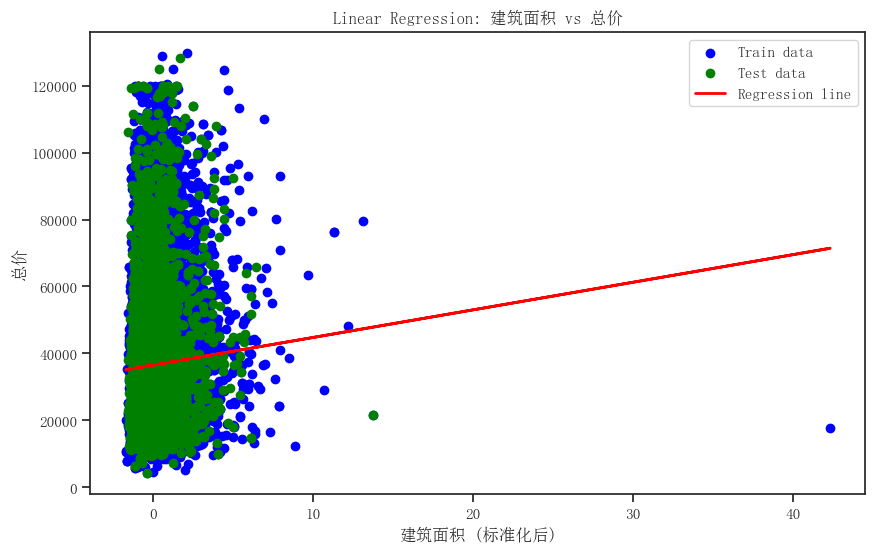

In [125]:
# 尝试单变量线性回归
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 加载数据
data = pd.read_csv('data_featured.csv')
data = data.astype(float)

# 选择单一特征和目标变量
X = data[['建筑面积']]  # 假设我们选择 '建筑面积' 作为单一特征
y = data['单价']

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数值特征
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# 训练线性回归模型
model = LinearRegression()
model.fit(X_train, y_train)

# 预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 评估模型
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

# 绘制拟合线
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Train data')
plt.scatter(X_test, y_test, color='green', label='Test data')
plt.plot(X_train, y_train_pred, color='red', linewidth=2, label='Regression line')
plt.xlabel('建筑面积 (标准化后)')
plt.ylabel('总价')
plt.title('Linear Regression: 建筑面积 vs 总价')
plt.legend()
plt.show()

## 尝试第二种：随机森林回归

In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [131]:
# 读取数据
data = pd.read_csv('data_featured.csv')
data = data.astype(float)

data = data[np.isfinite(data).all(1)]
data = data.dropna()

# 选择特征和目标变量
X = data.drop(columns=['单价', '序号', '链家编号'])  # 假设 '总价' 是目标变量，'序号' 不是特征
y = data['单价']

# 拆分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化数值特征
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# 标准化目标变量
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [132]:
# 训练随机森林回归模型并记录损失
model = RandomForestRegressor(n_estimators=100, warm_start=True, random_state=42)

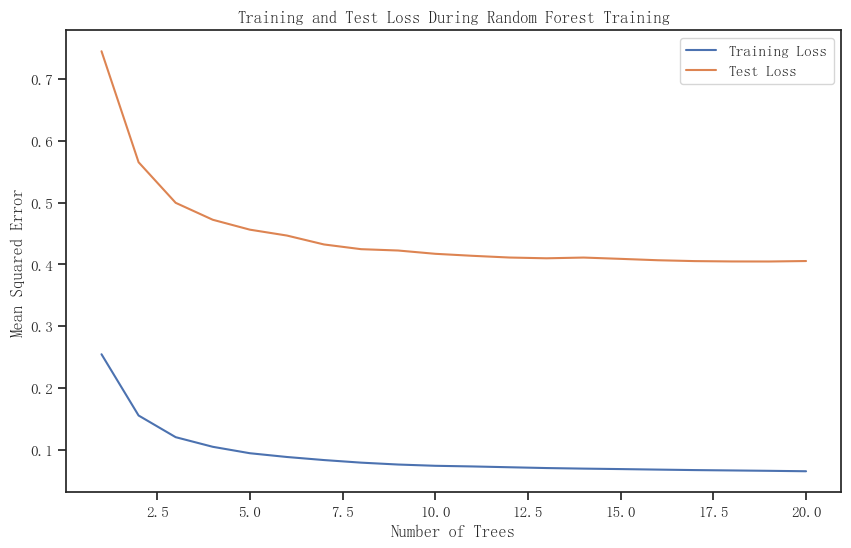

In [133]:
train_losses = []
test_losses = []

for i in range(1, 21):
    model.n_estimators = i
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    train_losses.append(train_mse)
    test_losses.append(test_mse)

# 绘制损失图像
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_losses, label='Training Loss')
plt.plot(range(1, 21), test_losses, label='Test Loss')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Loss During Random Forest Training')
plt.legend()
plt.show()

In [134]:
# 反标准化预测结果
y_train_pred_original = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred_original = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

# 计算反标准化后的 MSE
train_mse_original = mean_squared_error(scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(), y_train_pred_original)
test_mse_original = mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(), y_test_pred_original)

print(f'Final Training MSE: {train_mse_original}')
print(f'Final Test MSE: {test_mse_original}')

Final Training MSE: 22441303.45287401
Final Test MSE: 138455300.42125723


In [ ]:
葱苓sama🅥⁧喵⁧‭